In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import helper

In [2]:
START_DATE='1969-01-01'
END_DATE='2023-05-18'
excess_returns, commodity_market_factor = helper.loading_and_pre_processing('data.xlsx', nan_method='zero', START_DATE=START_DATE, END_DATE=END_DATE)

/Users/salimtlemcani/Desktop/Work/University/Imperial College London/2022/Term 3/ATS_perso/coursework_backtesting/helper.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_excess_returns.columns = raw_excess_returns.columns.str.replace(r'\s+', '_').str.upper()
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [3]:
class CourseworkFramework:
    def __init__(self):
        self.rolling_table = pd.DataFrame(columns=['Date', 
                                                   'Ticker', 
                                                   'buy_or_sell', 
                                                   'opened_or_closed', 
                                                   'weight', 
                                                   'non_weighted_return', 
                                                   'weighted_return',
                                                   'max_drawdown', 
                                                   'max_drawdown_start_date', 
                                                   'max_drawdown_end_date', 
                                                   'kurtosis', 
                                                   'skewness', 
                                                   'win_rate'])
        
        self.signals_high_low_breakout = pd.DataFrame(index=excess_returns.index, columns=excess_returns.columns)
        self.signals_mean_std_breakout = pd.DataFrame(index=excess_returns.index, columns=excess_returns.columns)
        
    def high_low_breakout(self, excess_returns, window=40):
        """
        Parameters:
            excess_returns (pandas.DataFrame)
            window (int)

        Returns:
            signals_high_low_breakout (pandas.Dataframe)
        """

        self.signals_high_low_breakout = pd.DataFrame(index=excess_returns.index, columns=excess_returns.columns)

        for timestamp in excess_returns.index:

            for ticker in excess_returns.columns:
                signal = 0 # No signal (yet)
                current_excess_return = excess_returns.loc[timestamp, ticker]
                highest_return = excess_returns[ticker].rolling(window).max().loc[timestamp]
                lowest_return = excess_returns[ticker].rolling(window).min().loc[timestamp]

                if current_excess_return == highest_return:
                    signal = 1 # Buy signal

                if current_excess_return == lowest_return:
                    signal = -1 # Sell signal

                self.signals_high_low_breakout.loc[timestamp, ticker] = signal
        return self.signals_high_low_breakout
    
    def mean_std_breakout(self, excess_returns, window=40):
        """
        Parameters:
            excess_returns (pandas.DataFrame)
            window (int)

        Returns:
            signals_mean_std_breakout (pandas.Dataframe)
        """

        self.signals_mean_std_breakout = pd.DataFrame(index=excess_returns.index, columns=excess_returns.columns)

        for timestamp in excess_returns.index:

            for ticker in excess_returns.columns:
                signal = 0 # No signal (yet)
                current_excess_return = excess_returns.loc[timestamp, ticker]

                mean_return = excess_returns[ticker].rolling(window).mean().loc[timestamp]
                std_return = excess_returns[ticker].rolling(window).std().loc[timestamp]

                if current_excess_return >= mean_return :
                    signal = 1 # Buy signal

                if current_excess_return <= mean_return :
                    signal = -1 # Sell signal

                self.signals_mean_std_breakout.loc[timestamp, ticker] = signal
        return self.signals_mean_std_breakout

    def convert_signal_to_position(self, signals):
        """
        Parameters:
            signals (pandas.DataFrame)

        Returns:
            converted_signals (pandas.Dataframe)
        """
        self.converted_signals = pd.DataFrame(index=signals.index, columns=signals.columns)
        for col in signals.columns:
            new_series = pd.Series(index=signals.index, dtype=int)
            position = ''
            state = 'hold'
            for idx,i in signals[col].items():
                if i > 0:
                    if position == 'buy':
                        state = 'hold'
                        new_series[idx] = state
                    else:
                        position = 'buy'
                        state = 'buy'
                        new_series[idx] = state
                elif i < 0:
                    if position == 'sell':
                        state = 'hold'
                        new_series[idx] = state
                    else:
                        position = 'sell'
                        state = 'sell'
                        new_series[idx] = state
                else :
                    state = 'hold'
                    new_series[idx] = state
            self.converted_signals[col] = new_series
        return self.converted_signals

    def calculate_max_drawdown(self, returns):
        """
        Parameters:
            returns (pandas.Series)

        Returns:
            (float). refers to max drawdown
            drawdown_start_date (datetime64[ns]). format: YYYY-MM-DD.
            drawdown_end_date (datetime64[ns]). format: YYYY-MM-DD.
        """
        #check if the returns is a pandas.core.series.Series
        if not isinstance(returns, pd.Series):
            raise TypeError("returns must be a pandas.core.series.Series")
        drawdowns = []
        drawdown = returns[0]
        maxi = returns[0]
        drawdown_end_date = returns.index[0]
        drawdown_start_date = returns.index[0]

        for date,ret in returns.items():
            if ret > maxi: 
                maxi = ret
                drawdown_start_date = returns.index[0]


            if ret < drawdown: 
                drawdown = ret 
                drawdown_end_date = date

            drawdowns.append(drawdown)

        return -np.linalg.norm(maxi-drawdown), drawdown_start_date, drawdown_end_date

    def calculate_kurtosis(self, returns):
        """
        Parameters:
            returns (pandas.Series)

        Returns:
            kurtosis (float)
        """

        #check if the returns is a pandas.core.series.Series
        if not isinstance(returns, pd.Series):
            raise TypeError("returns must be a pandas.core.series.Series")

        #calculate
        kurtosis = returns.kurtosis()

        #output
        return kurtosis

    def calculate_skewness(self, returns):
        """
        Parameters:
            returns (pandas.Series)

        Returns:
            skewness (float)
        """

        #check if the returns is a pandas.core.series.Series
        if not isinstance(returns, pd.Series):
            raise TypeError("returns must be a pandas.core.series.Series")

        #calculate
        skewness = returns.skew()

        #output
        return skewness

    def calculate_win_rate(self, returns):
        """
        Parameters:
            returns (pandas.Series)

        Returns:
            win_rate (float)
        """
        #check if the returns is a pandas.core.series.Series
        if not isinstance(returns, pd.Series):
            raise TypeError("returns must be a pandas.core.series.Series")

        #calculate
        win_rate = (returns > 0).sum() / len(returns)
        # Return the win rate
        return win_rate


    def compute_rolling_table(self, converted_signals, weighted_signal=None):
        """
        Parameters:
            converted_signals (pandas.DataFrame)

        Returns:
            rolling_table (pandas.DataFrame)
        """

        cumulative_returns = pd.Series(0, index=converted_signals.index)
        rolling_table = []
        pending_tx = {}

        for ticker in converted_signals.columns:
            opened_or_closed = 'closed'
            # filter out hold to only keep buy/sell:
            for date, buy_or_sell in converted_signals[ticker][converted_signals[ticker] != 'hold'].items():
                if opened_or_closed == 'closed':
                    
                    opened_or_closed = 'opened'
                    opened_date = date
                    pending_tx[ticker] = opened_date
                    
                    if weighted_signal is not None: 
                        weight = weighted_signal[ticker].loc[date]
                    else: 
                        weight = 1
                    
                    rolling_table.append({
                        'Date': opened_date,
                        'Ticker': ticker,
                        'buy_or_sell': buy_or_sell,
                        'opened_or_closed': opened_or_closed,
                        'weight': weight,
                        'non_weighted_return': 0,
                        'weighted_return': 0,
                        'max_drawdown': 0,
                        'max_drawdown_start_date': None,
                        'max_drawdown_end_date': None,
                        'kurtosis': 0,
                        'skewness': 0,
                        'win_rate': 0,
                    })
                elif opened_or_closed == 'opened':

                    opened_or_closed = 'closed'
                    opened_date = pending_tx[ticker]
                    closed_date = date
                    
                    if weighted_signal is not None: 
                        weight = weighted_signal[ticker].loc[date]
                    else: 
                        weight = 1
#                     print(weight, excess_returns[ticker].loc[opened_date:closed_date].sum(), weight * excess_returns[ticker].loc[opened_date:closed_date].sum())
                    rolling_table.append({
                        'Date': closed_date,
                        'Ticker': ticker,
                        'buy_or_sell': buy_or_sell,
                        'opened_or_closed': opened_or_closed,
                        'weight': weight,
                        'non_weighted_return': excess_returns[ticker].loc[opened_date:closed_date].sum(),
                        'weighted_return': abs(weight) * excess_returns[ticker].loc[opened_date:closed_date].sum(),
                        'max_drawdown': self.calculate_max_drawdown(excess_returns[ticker].loc[opened_date:closed_date])[0],
                        'max_drawdown_start_date': self.calculate_max_drawdown(excess_returns[ticker].loc[opened_date:closed_date])[1],
                        'max_drawdown_end_date': self.calculate_max_drawdown(excess_returns[ticker].loc[opened_date:closed_date])[2],
                        'kurtosis': self.calculate_kurtosis(excess_returns[ticker].loc[opened_date:closed_date]),
                        'skewness': self.calculate_skewness(excess_returns[ticker].loc[opened_date:closed_date]),
                        'win_rate': self.calculate_win_rate(excess_returns[ticker].loc[opened_date:closed_date]),
                    })
                    del pending_tx[ticker]

        rolling_table = pd.DataFrame(rolling_table)
        rolling_table = rolling_table.sort_values(by='Date', ascending=True).reset_index(drop=True)
        rolling_table['cumulative return'] = rolling_table['non_weighted_return'].cumsum()
        self.rolling_table = rolling_table
        return self.rolling_table
    
    ### ADD PLOT FUNCTIONS 
    
    # get functions
    def get_rolling_table(self):
        return self.rolling_table
    
    def get_one_zero_minus_one_signals(self):
        return self.signals
    
    def get_buy_sell_signals(self):
        return self.converted_signals
    
    def get_strategy_returns(self):
        return self.strategy_returns
    

## Create a breakout strategy object based on 1 criterion

### The `high_low_breakout` criterion function

Create a strategy object with a set window.

In [4]:
strategy1 = CourseworkFramework()
window = 5

Run a strategy `high_low_breakout`, get the strategy rolling table and plot the performance

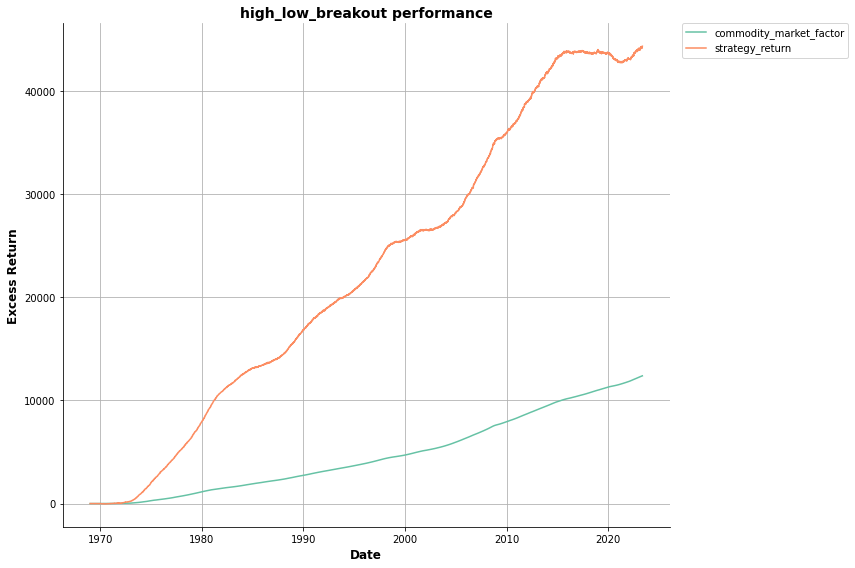

In [5]:
signals_hlb = strategy1.high_low_breakout(excess_returns, window)
converted_signals = strategy1.convert_signal_to_position(signals_hlb)
rolling_table = strategy1.compute_rolling_table(converted_signals)
performance = pd.DataFrame(rolling_table.groupby('Date')['non_weighted_return'].sum())
performance.rename(columns = {list(performance)[0]: 'strategy_return'}, inplace = True)
helper.plot_df(pd.merge(commodity_market_factor.cumsum(), performance.cumsum(), on='Date'), title='high_low_breakout performance')

### The `mean_std_breakout` criterion function

Run a strategy `mean_std_breakout`, get the strategy rolling table and plot the performance

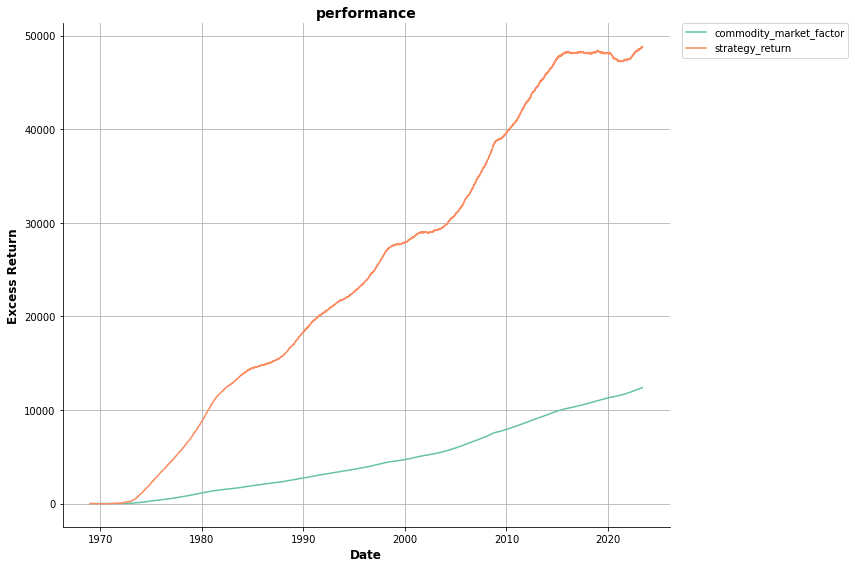

In [12]:
strategy2 = CourseworkFramework()
window = 5
signals_msb = strategy2.mean_std_breakout(excess_returns, window)
converted_signals = strategy2.convert_signal_to_position(signals_msb)
rolling_table = strategy2.compute_rolling_table(converted_signals)
performance = pd.DataFrame(rolling_table.groupby('Date')['non_weighted_return'].sum())
performance.rename(columns = {list(performance)[0]: 'strategy_return'}, inplace = True)
helper.plot_df(pd.merge(commodity_market_factor.cumsum(), performance.cumsum(), on='Date'), title='performance')

In [13]:
try:
    rolling_table.to_excel(f'rolling_table_mean_std_breakout.xlsx')
    print(f"Excel file created successfully: rolling_table_mean_std_breakout.xlsx")
except:
    print(f"ERROR: Could not create excel file: rolling_table_mean_std_breakout.xlsx")
try:
    performance.to_excel(f'performance_mean_std_breakout.xlsx')
    print(f"Excel file created successfully: performance_mean_std_breakout.xlsx")
except:
    print(f"ERROR: Could not create excel file: performance_mean_std_breakout.xlsx")
merged_df = pd.merge(commodity_market_factor.cumsum(), performance.cumsum(), on='Date')
try:
    merged_df.to_excel(f'merged_df_mean_std_breakout.xlsx')
    print(f"Excel file created successfully: merged_df_mean_std_breakout.xlsx")
except:
    print(f"ERROR: Could not create excel file: merged_df_mean_std_breakout.xlsx")

<ipython-input-13-da6c4717e80d>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  rolling_table.to_excel(f'rolling_table_mean_std_breakout.xlsx')


Excel file created successfully: rolling_table_mean_std_breakout.xlsx


<ipython-input-13-da6c4717e80d>:7: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  performance.to_excel(f'performance_mean_std_breakout.xlsx')


Excel file created successfully: performance_mean_std_breakout.xlsx


<ipython-input-13-da6c4717e80d>:13: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  merged_df.to_excel(f'merged_df_mean_std_breakout.xlsx')


Excel file created successfully: merged_df_mean_std_breakout.xlsx


## Combine signals
This time, we will run a strategy combining the two aforementioned breakout criteria

In [7]:
strategy3 = CourseworkFramework()
window = 5
signals_hlb = strategy3.high_low_breakout(excess_returns, window)
signals_msb = strategy3.mean_std_breakout(excess_returns, window)

Combine the signals by adding the two signal dataframe and dividing them by 2. the possible weights are now : 1, 0.5, 0, -0.5, -1

In [8]:
combine = (signals_msb+signals_hlb)/2
combine.head()

,LIVE_CATTLE_FUTR_AUG23,LEAN_HOGS_FUTURE_JUL23,COFFEE_'C'_FUTURE_JUL23,CORN_FUTURE_JUL23,COTTON_NO.2_FUTR_JUL23,SOYBEAN_FUTURE_JUL23,SUGAR_#11_(WORLD)_JUL23,WHEAT_FUTURE(CBT)_JUL23,BRENT_CRUDE_FUTR_JUL23,COPPER_FUTURE_JUL23,...,SILVER_FUTURE_JUL23,PLATINUM_FUTURE_JUL23,WTI_CRUDE_FUTURE_JUN23,LME_NICKEL,LME_COPPER,LME_ALUMINIUM,LME_LEAD,LME_ZINC,COCOA_FUTURE_JUL23,HEATING_OIL
Date,,,,,,,,,,,,,,,,,,,,,
1969-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-01-07,0.5,-1.0,-1.0,1.0,-0.5,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Get the strategy rolling table and plot the performance 

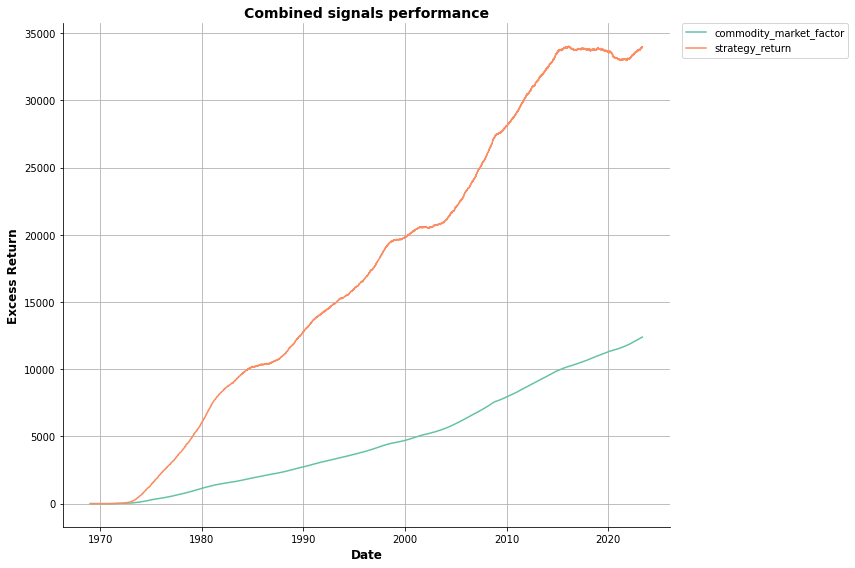

In [9]:
converted_signals = strategy3.convert_signal_to_position(combine)
rolling_table = strategy3.compute_rolling_table(converted_signals, combine)
performance = pd.DataFrame(rolling_table.groupby('Date')['weighted_return'].sum())
performance.rename(columns = {list(performance)[0]: 'strategy_return'}, inplace = True)
helper.plot_df(pd.merge(commodity_market_factor.cumsum(), performance.cumsum(), on='Date'), title='Combined signals performance')

In [11]:
try:
    rolling_table.to_excel(f'rolling_table_combined.xlsx')
    print(f"Excel file created successfully: rolling_table_combined.xlsx")
except:
    print(f"ERROR: Could not create excel file: rolling_table_combined.xlsx")
try:
    performance.to_excel(f'performance_combined.xlsx')
    print(f"Excel file created successfully: performance_combined.xlsx")
except:
    print(f"ERROR: Could not create excel file: performance_combined.xlsx")
merged_df = pd.merge(commodity_market_factor.cumsum(), performance.cumsum(), on='Date')
try:
    merged_df.to_excel(f'merged_df_combined.xlsx')
    print(f"Excel file created successfully: merged_df_combined.xlsx")
except:
    print(f"ERROR: Could not create excel file: merged_df_combined.xlsx")

<ipython-input-11-ed1281fa76a7>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  rolling_table.to_excel(f'rolling_table_combined.xlsx')


Excel file created successfully: rolling_table_combined.xlsx


<ipython-input-11-ed1281fa76a7>:7: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  performance.to_excel(f'performance_combined.xlsx')


Excel file created successfully: performance_combined.xlsx


<ipython-input-11-ed1281fa76a7>:13: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  merged_df.to_excel(f'merged_df_combined.xlsx')


Excel file created successfully: merged_df_combined.xlsx
